<a href="https://colab.research.google.com/github/cjhenry10/big-data-ai/blob/main/final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import math
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
import seaborn as sns
# video used:
# https://www.youtube.com/watch?v=tepxdcepTbY&ab_channel=DigitalSreeni

In [62]:
# get stock df
df = yf.Ticker('^NYA').history(period='5y')
df['Date'] = pd.to_datetime(df.index).date
# df.dtypes
# uses all 7 columns: open, high, low,
# close, volume, dividends, stock splits
cols = list(df)[0:7]


df_for_training = df[cols].astype(float)

In [63]:
# normalize the data for the model
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

train_x = []
train_y = []

n_future = 1 #number of days into future to predict
n_past = 60  #number of days in the past to use to predict

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
  train_x.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
  train_y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

train_x, train_y = np.array(train_x), np.array(train_y)

print('train_x shape = {}'.format(train_x.shape))
print('train_y shape = {}'.format(train_y.shape))

train_x shape = (1199, 60, 7)
train_y shape = (1199, 1)


In [21]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            18432     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(train_x, train_y, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
68/68 [==============================] - 9s 135ms/step - loss: 0.0272 - val_loss: 0.0129
Epoch 2/10
68/68 [==============================] - 4s 57ms/step - loss: 0.0278 - val_loss: 0.0156
Epoch 3/10
68/68 [==============================] - 4s 56ms/step - loss: 0.0264 - val_loss: 0.0188
Epoch 4/10
68/68 [==============================] - 5s 72ms/step - loss: 0.0221 - val_loss: 0.0140
Epoch 5/10
68/68 [==============================] - 4s 57ms/step - loss: 0.0195 - val_loss: 0.0153
Epoch 6/10
68/68 [==============================] - 4s 55ms/step - loss: 0.0193 - val_loss: 0.0145
Epoch 7/10
68/68 [==============================] - 5s 71ms/step - loss: 0.0204 - val_loss: 0.0190
Epoch 8/10
68/68 [==============================] - 4s 55ms/step - loss: 0.0186 - val_loss: 0.0118
Epoch 9/10
68/68 [==============================] - 4s 56ms/step - loss: 0.0208 - val_loss: 0.0315
Epoch 10/10
68/68 [==============================] - 5s 73ms/step - loss: 0.0178 - val_loss: 0.0203


1/1 [==============================] - 0s 65ms/step


<ipython-input-87-a0f2dfb80ffc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


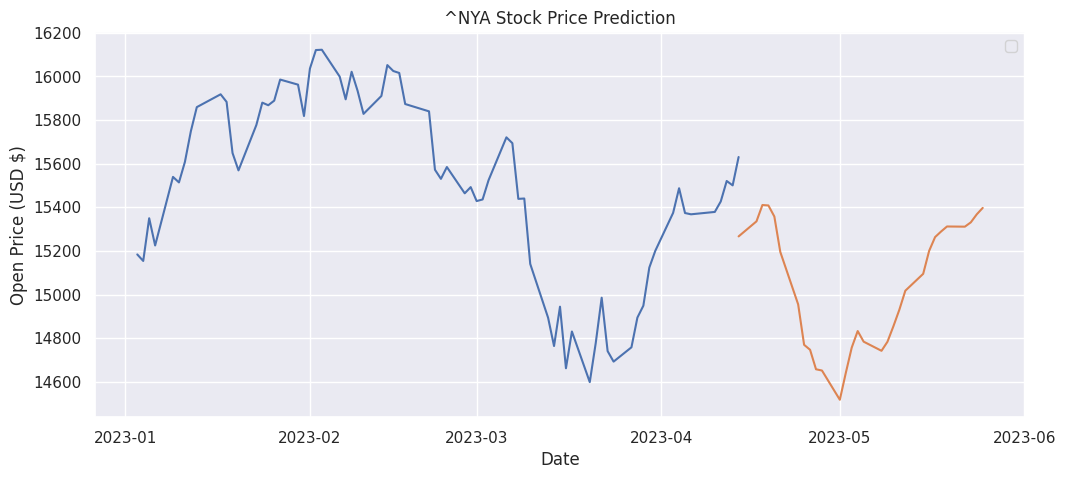

In [87]:
# libaries to only make business day predictions
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

days_future = 30
forecast_period_dates = pd.date_range(list(df.index)[-1], periods=days_future, freq=us_bd).tolist()

forecast = model.predict(train_x[-days_future:])
# transform back to original range for predictions w/5 copies to match the original shape
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0] # 0 for just Open prediction

# convert to dates
forecast_dates = []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future,})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-01-01']

sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])
sns.set(rc={'figure.figsize':(12,5)})
plt.title('^NYA Stock Price Prediction')
plt.ylabel('Open Price (USD $)')
# plt.plot(original[['Open', 'Date']])
# plt.plot(df_forecast[['Open', 'Date']])
plt.legend(labels=['History', 'Prediction'], loc='lower right')
plt.legend()